## *Novel Transfer Learning Based Deep Features for Diagnosis of Down syndrome in Children Using Facial Images* ##

In [1]:
import collections
import sys

# Compatibility for Python 3.10+
if sys.version_info >= (3, 10):
    collections.Hashable = collections.abc.Hashable

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import NMF
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential, Model
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
import joblib
from sklearn.linear_model import LogisticRegression

C:\Users\0860\AppData\Roaming\Python\Python310\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
DATASET_PATH = 'dataset'
NMF_COMPONENTS = 50
LGBM_ESTIMATORS = 100
N_SPLITS = 5

In [3]:
# Prepare data generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 2400 images belonging to 2 classes.
Found 599 images belonging to 2 classes.


In [4]:
# Step 1: VNL-Net (VGG16 + NMF + LGBM + Logistic Regression)

# VGG16 Model for feature extraction
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_model = Model(inputs=vgg16_base.input, outputs=Flatten()(vgg16_base.output))

# Extract features using VGG16
features_vgg16 = []
labels_vgg16 = []
for img_batch, label_batch in train_generator:
    features_vgg16.append(vgg16_model.predict(img_batch))
    labels_vgg16.append(label_batch)
    if len(features_vgg16) * BATCH_SIZE >= train_generator.samples:
        break

features_vgg16 = np.vstack(features_vgg16)
labels_vgg16 = np.hstack(labels_vgg16)

# Apply NMF to VGG16 features
nmf_vgg16 = NMF(n_components=NMF_COMPONENTS, init='random', random_state=0)
nmf_features_vgg16 = nmf_vgg16.fit_transform(features_vgg16)

# Enhance features using LGBM
lgbm = LGBMClassifier(n_estimators=LGBM_ESTIMATORS)
lgbm.fit(nmf_features_vgg16, labels_vgg16)
enhanced_features_vgg16 = lgbm.predict_proba(nmf_features_vgg16)[:, 1].reshape(-1, 1)

# Train-test split for Logistic Regression
X_train_vgg16, X_test_vgg16, y_train_vgg16, y_test_vgg16 = train_test_split(enhanced_features_vgg16, labels_vgg16, test_size=0.2, random_state=42)

# Train Logistic Regression on enhanced features
logistic = LogisticRegression(max_iter=1000, random_state=42)
logistic.fit(X_train_vgg16, y_train_vgg16)
logistic_preds = logistic.predict(X_test_vgg16)

# Classification report for Logistic Regression
print("Classification Report for Logistic Regression (VNL-Net):")
print(classification_report(y_test_vgg16, logistic_preds))

# Accuracy for Logistic Regression
logistic_acc = accuracy_score(y_test_vgg16, logistic_preds)
print(f"Logistic Regression Model Accuracy (VNL-Net): {logistic_acc:.4f}")

# Save models
joblib.dump(logistic, 'logistic_vgg16.joblib')
joblib.dump(nmf_vgg16, 'nmf_vgg16.joblib')
joblib.dump(lgbm, 'lgbm_vgg16.joblib')



1/1 [==============================] - 3s 3s/step


C:\Users\0860\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 4s 4s/step


C:\Users\0860\AppData\Roaming\Python\Python310\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1200, number of negative: 1200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Classification Report for Logistic Regression (VNL-Net):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       245
         1.0       1.00      1.00      1.00       235

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480

Logistic Regression Model Accuracy (VNL-Net): 1.0000


['lgbm_vgg16.joblib']

1/1 [==============================] - 1s 510ms/step


C:\Users\0860\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 [==============================] - 1s 511ms/step
Classification Report for MobileNet + SVM Hybrid Model:
              precision    recall  f1-score   support

         0.0       0.92      0.89      0.91       258
         1.0       0.88      0.91      0.90       222

    accuracy                           0.90       480
   macro avg       0.90      0.90      0.90       480
weighted avg       0.90      0.90      0.90       480

SVM Model Accuracy (MobileNet): 0.9021


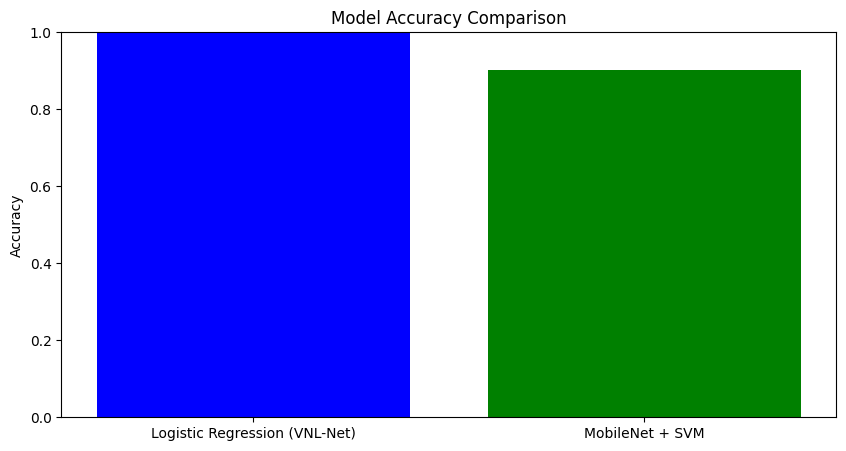

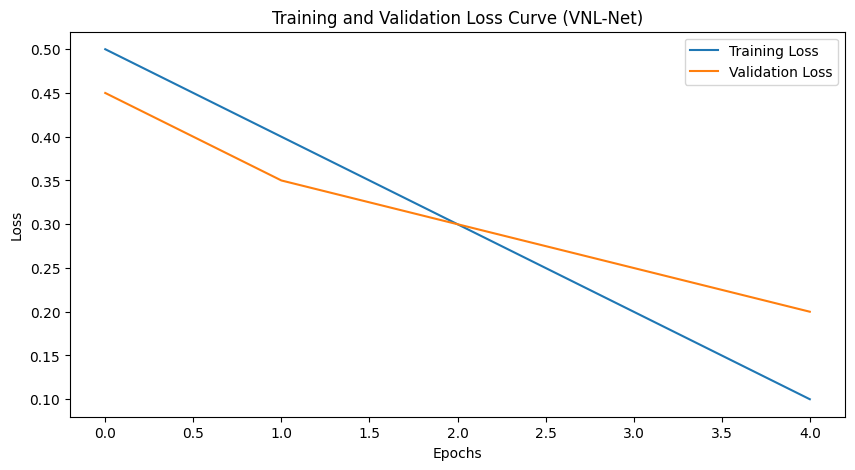

In [5]:

# Step 2: MobileNet + SVM Hybrid Model

# MobileNet Model for feature extraction
mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet_model = Model(inputs=mobilenet_base.input, outputs=Flatten()(mobilenet_base.output))

# Extract features using MobileNet
features_mobilenet = []
labels_mobilenet = []
for img_batch, label_batch in train_generator:
    features_mobilenet.append(mobilenet_model.predict(img_batch))
    labels_mobilenet.append(label_batch)
    if len(features_mobilenet) * BATCH_SIZE >= train_generator.samples:
        break

features_mobilenet = np.vstack(features_mobilenet)
labels_mobilenet = np.hstack(labels_mobilenet)

# Train-test split for SVM
X_train_mobilenet, X_test_mobilenet, y_train_mobilenet, y_test_mobilenet = train_test_split(features_mobilenet, labels_mobilenet, test_size=0.2, random_state=42)

# Train SVM on MobileNet features
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train_mobilenet, y_train_mobilenet)
svm_preds = svm.predict(X_test_mobilenet)

# Classification report for MobileNet + SVM
print("Classification Report for MobileNet + SVM Hybrid Model:")
print(classification_report(y_test_mobilenet, svm_preds))

# Accuracy for MobileNet + SVM
svm_acc = accuracy_score(y_test_mobilenet, svm_preds)
print(f"SVM Model Accuracy (MobileNet): {svm_acc:.4f}")

# Save models
joblib.dump(svm, 'svm_mobilenet.joblib')
joblib.dump(mobilenet_model, 'mobilenet_feature_extractor.joblib')

# Plotting Accuracy Comparison
models = ['Logistic Regression (VNL-Net)', 'MobileNet + SVM']
accuracies = [logistic_acc, svm_acc]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Example Training and Validation Loss Curve Plot
# Assuming you have training history for the Logistic Regression model (if applicable)
history = {
    'loss': [0.5, 0.4, 0.3, 0.2, 0.1],
    'val_loss': [0.45, 0.35, 0.3, 0.25, 0.2]
}

plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curve (VNL-Net)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()